## Import

In [1]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Data

In [2]:
df = pd.read_csv('./datasets/sleep_Modeling.csv', index_col = [0])

In [3]:
df.head()

,awake_time,start_work,end_work,bed_time_work_tomorrow,no_work_awake_time,bed_time_no_work_tomorrow,usual_sleep_per_night,naps_per_month,length_of_average_nap,employment_status,...,highest_edu_Some college,highest_edu_Some high school,highest_edu_Vocational/Tech school,single_dual_household_Single income,"house_hold_income_bracket_$25,001 - $35,000","house_hold_income_bracket_$35,001 - $50,000","house_hold_income_bracket_$50,001 - $75,000","house_hold_income_bracket_More than $100,000",house_hold_income_bracket_NA,"house_hold_income_bracket_Under $15,000"
0,7:00 AM – 7:14 AM,9:00 AM – 9:14 AM,6:45 AM – 6:59 AM,8:45 AM – 8:59 AM,7:00 AM – 7:14 AM,8:30 AM – 8:44 AM,7.000000,0,0.0,1,...,1,0,0,1,0,1,0,0,0,0
1,5:00 AM – 5:14 AM,7:00 AM – 7:14 AM,7:00 AM – 7:14 AM,7:15 AM – 7:29 AM,7:00 AM – 7:14 AM,7:45 AM – 7:59 AM,6.000000,25,15.0,2,...,0,0,1,0,0,1,0,0,0,0
2,12:01 AM – 4:59 AM,5:00 AM – 5:14 AM,7:15 AM – 7:29 AM,7:45 AM – 7:59 AM,7:00 AM – 7:14 AM,7:45 AM – 7:59 AM,5.000000,0,0.0,2,...,1,0,0,0,0,0,0,1,0,0
3,5:45 AM – 5:59 AM,7:00 AM – 7:14 AM,6:30 AM – 6:44 AM,8:45 AM – 8:59 AM,8:00 AM – 8:14 AM,12:00 AM,6.500000,10,60.0,2,...,1,0,0,0,0,1,0,0,0,0
4,12:01 AM – 4:59 AM,8:30 AM – 8:44 AM,7:15 AM – 7:29 AM,8:15 AM – 8:29 AM,5:30 AM – 5:44 AM,8:45 AM – 8:59 AM,6.655158,1,60.0,2,...,0,0,0,0,0,0,0,1,0,0


In [4]:
condition_col = 'has_condition'

In [5]:
#Undersample non-target observations

df_no = df[df[condition_col] == 0]
df_no = df_no[:300]
df= pd.concat([df_no, df[df[condition_col] == 1]])
df.shape

(670, 179)

## Predicting - Has Condition

In [6]:
# Select target
y = df[condition_col]

**Features**

In [7]:
#Features - Treated for columns will be used as targets. Other columns to be used as targets:
treated = [x for x in df.columns if x[:8] == 'treated_']
marital = [x for x in df.columns if x[:8] == 'marital_']
edu = [x for x in df.columns if x[:8] == 'highest_']
income = [x for x in df.columns if x[:8] == 'house_']
start_work = [x for x in df.columns if x[:12] == 'start_work_']
end_work = [x for x in df.columns if x[:9] == 'end_work_']
extra_cols = ['age','poor_sleep', 'has_condition', 'avg_weekly_hours_worked',
              'single_dual_household_Single income','employment_status']
bed_time_work = [x for x in df.columns if x[:len('bed_time_work_tomorrow_')] == 'bed_time_work_tomorrow_']
bed_time_no_work = [x for x in df.columns if x[:len('bed_time_no_work_tomorrow_')] == 'bed_time_no_work_tomorrow_']
no_work = [x for x in df.columns if x[:len('no_work_awake_time_')] == 'no_work_awake_time_']
awake = [x for x in df.columns if x[:11] == 'awake_time_']

In [8]:
# X = df[bed_time_work + bed_time_no_work + ['naps_per_month', 'length_of_average_nap', 'snores']]

In [9]:
#Select independent variables
X = df[['usual_sleep_per_night','unconvential_awake_time', 'naps_per_month', 'length_of_average_nap']]

In [10]:
for i in X.columns:
    print(i)

usual_sleep_per_night
unconvential_awake_time
naps_per_month
length_of_average_nap


**Baseline:**

In [11]:
#Find the baseline score

df[condition_col].value_counts(normalize = True)[1]

0.5522388059701493

**Spilt the data into test/train**

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42)

**Use SMOTE to fix class imbalances**

In [13]:
# os = SMOTE(k_neighbors=3, sampling_strategy='auto', n_jobs = -1)
# X_train, y_train = SMOTE().fit_resample(X_train, y_train)

In [14]:
y_train.value_counts(normalize = True)

1    0.565299
0    0.434701
Name: has_condition, dtype: float64

**KNN with GridSearch**

In [15]:
# Instantiate model
knn = KNeighborsClassifier()

# Scale data
s = StandardScaler()

# Create pipeline to run scaler and model through
pipe = Pipeline([('s', s),('knn', knn)])

# Select hyperparameters for Grid Search tuning
prms = {'s__with_mean': [True, False],
        's__with_std': [True, False],
        'knn__weights':['uniform', 'distance'],
        'knn__leaf_size':[1,5,10],
        'knn__n_neighbors': [3,],
        'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
       }

# Grid Search
gs_knn = GridSearchCV(pipe, prms, n_jobs = -1)

# Fit model
gs_knn.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('s', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__algorithm': ['auto', 'ball_tree', 'kd_tree',
                                            'brute'],
                         'knn__leaf_size': [1, 5, 10], 'knn__n_neighbors': [3],
                         'knn__weights': ['uniform', 'distance'],
                         's__with_mean': [True, False],
                         's__with_std': [True, False]})

In [16]:
# Best parameters after Grid Search

gs_knn.best_params_

{'knn__algorithm': 'auto',
 'knn__leaf_size': 5,
 'knn__n_neighbors': 3,
 'knn__weights': 'uniform',
 's__with_mean': True,
 's__with_std': False}

In [17]:
# Accuracy score

gs_knn.best_score_

0.5896157840083074

In [18]:
# Generate predictions

knn_preds = gs_knn.predict(X_test)

In [19]:
# Accuracy of training set

gs_knn.score(X_train, y_train)

0.6865671641791045

In [20]:
#Accuracy on testing set

gs_knn.score(X_test, y_test)

0.5223880597014925

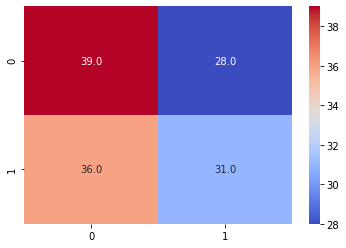

In [21]:
cmx = confusion_matrix(y_test, knn_preds)
sns.heatmap(cmx, annot = True, fmt = '.1f', cmap = 'coolwarm');

In [22]:
print('Precision:', round(precision_score(y_test, knn_preds),2))
print('Accuracy:', round(accuracy_score(y_test, knn_preds),2))
print('Recall:', round(recall_score(y_test, knn_preds),2))
print('F1: ', round(f1_score(y_test, knn_preds),2))

Precision: 0.53
Accuracy: 0.52
Recall: 0.46
F1:  0.49


The KNN model was overfit, however, unlike the logistic regression model, it was better at predicting the target. It still had trouble distinguishing between true positives and false positives.  The f1 scores are higher and the confusion matrix shows greater values for true positives/negatives than false positives/negatives.